Following https://www.tensorflow.org/datasets/keras_example to understand tf datasets and then trying different models

In [21]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [24]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [15]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\joshu\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

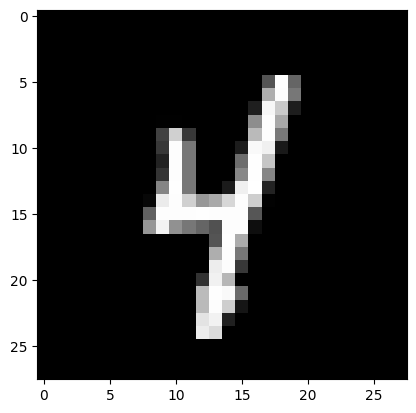

In [35]:
img = ds_train.take(1).as_numpy_iterator().next()[0]
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

In [36]:
# normalize images to be in [0, 1] range
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# cache dataset to memory to speed up training
ds_train = ds_train.cache()

# shuffle dataset
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)

# create batches
ds_train = ds_train.batch(128)

# prefetch so it loads data in the background
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [38]:
# normalize test set
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# create batches
ds_test = ds_test.batch(128)

# cache
ds_test = ds_test.cache()

# prefetch
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [69]:
EPOCHS = 6

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.AveragePooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.AveragePooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  # tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

model.evaluate(ds_test, verbose=2)

Epoch 1/6
469/469 [==============================] - 50s 101ms/step - loss: 0.2982 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.0796 - val_sparse_categorical_accuracy: 0.9751
Epoch 2/6
469/469 [==============================] - 47s 101ms/step - loss: 0.0902 - sparse_categorical_accuracy: 0.9732 - val_loss: 0.0486 - val_sparse_categorical_accuracy: 0.9829
Epoch 3/6
469/469 [==============================] - 47s 99ms/step - loss: 0.0652 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.0410 - val_sparse_categorical_accuracy: 0.9860
Epoch 4/6
469/469 [==============================] - 42s 89ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.0394 - val_sparse_categorical_accuracy: 0.9863
Epoch 5/6
469/469 [==============================] - 39s 84ms/step - loss: 0.0443 - sparse_categorical_accuracy: 0.9862 - val_loss: 0.0331 - val_sparse_categorical_accuracy: 0.9894
Epoch 6/6
469/469 [==============================] - 38s 81ms/step - loss: 0.0358 - sparse_ca

[0.029312871396541595, 0.9905999898910522]

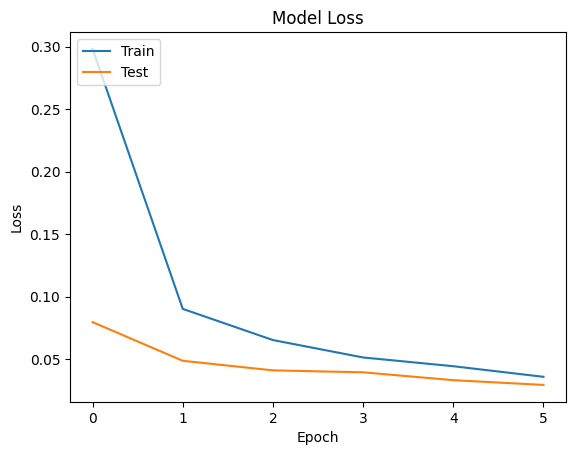

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Experiment Notes

- flatten, dense 128 relu: 0.9737 val accuracy
- flatten, dense 128 relu, dropout 0.2: 0.9735 but much smoother graph
- learning rate from 0.001 to 0.0001: training loss quickly gets worse again
- flatten, dense 128 relu, dense 64 relu, dropout 0.2: 0.9773
- flatten, dense 128 sigmoid, dense 64 sigmoid, dropout 0.2: 0.9646
- conv 32 relu, maxpool, flatten, dense 128 relu, dense 64 relu, dropout 0.2: 0.9876
- conv 32 relu, maxpool, flatten, dense 128 relu, dropout 0.2: 0.9873 (second dense layer doesn't seem to help)
- conv 32 relu, average pooling, flatten, dense 128 relu, dropout 0.2: 0.9877 (interesting because from what I understand average max pooling should be better here as it emphasizes the contrast)
- conv 32 relu, average pooling, conv 64, average pooling, flatten, dense 128 relu, dropout 0.2: 0.9906